# Import Library & Packages

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, FunctionTransformer, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, KMeans
from yellowbrick.cluster import KElbowVisualizer
from datetime import datetime
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.exceptions import UndefinedMetricWarning

# Pipeline

In [158]:
# Function to convert boolean values to integers
def bool_to_int(X):
    bool_columns = X.select_dtypes(include='bool').columns
    X.loc[:, bool_columns] = X.loc[:, bool_columns].astype(int)
    return X

In [159]:
# Define custom transformer to select columns
class ColumnSelector:
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.columns]

In [160]:
initial_columns = ['Income_Category_High', 'Income_Category_Low', 'Income_Category_Medium',
                   'Complain', 'Is_Parent', 'Cmp_Attitude', 'Family_Size', 'Age',
                   'Member_Year', 'Total_amount', 'Total_purchase',
                   'NumWebVisitsMonth', 'NumDealsPurchases', 'Recency']

In [161]:
# Define the pipeline steps
pipeline = Pipeline([
    ('select_columns', ColumnSelector(columns=initial_columns)),
    ('bool_to_int', FunctionTransformer(func=bool_to_int, validate=False)),
    ('preprocessing', StandardScaler()),  # Standardize the data
    ('pca', PCA(n_components=3, random_state=42)),  # PCA for dimensionality reduction
    ('clustering', KMeans())  # Default is KMeans, to be replaced by the best clustering algorithm
])

In [162]:
# Define parameters grid for grid search
param_grid = [
    {
        'clustering': [KMeans()],
        'clustering__n_clusters': range(2, 11)  # Range of clusters for KMeans
    },
    {
        'clustering': [AgglomerativeClustering()],
        'clustering__n_clusters': range(2, 11)  # Range of clusters for AgglomerativeClustering
    },
    {
        'clustering': [GaussianMixture()],
        'clustering__n_components': range(2, 11)  # Range of components for GaussianMixture
    }
]

In [163]:
def silhouette_scorer(estimator, X):
    try:
        labels = estimator.predict(X)  # Use predict to get labels directly
        if np.any(pd.isna(labels)):
            return float('-inf')  # Use negative infinity to denote bad scoring
        return silhouette_score(X, labels)
    except Exception as e:
        return float('-inf')

In [164]:
# Data Import
path = "/Users/qianlou/Documents/GitHub/Customer-Personality-Analysis-2.0/Data/Preprocessed Data/Final Preprocessed Data.csv"
df = pd.read_csv(path)

# Suppress warnings related to undefined metrics
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Perform grid search for hyperparameter tuning
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=silhouette_scorer)

# Fit the grid search without specifying the target column
grid_search.fit(df[initial_columns])

# Get the best model
best_model = grid_search.best_estimator_

# Fit the best model on the entire dataset
best_model.fit(df)

# Access the cluster labels
cluster_labels = best_model.named_steps['clustering'].labels_

# Add cluster labels to the original DataFrame
df['Clusters'] = cluster_labels


/var/folders/z4/djkh1_vd3bb6xf3hy80b_l9m0000gn/T/ipykernel_78047/1823657135.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 1 1 ... 1 1 1]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  X.loc[:, bool_columns] = X.loc[:, bool_columns].astype(int)
/var/folders/z4/djkh1_vd3bb6xf3hy80b_l9m0000gn/T/ipykernel_78047/1823657135.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  X.loc[:, bool_columns] = X.loc[:, bool_columns].astype(int)
/var/folders/z4/djkh1_vd3bb6xf3hy80b_l9m0000gn/T/ipykernel_78047/1823657135.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explic

In [17]:
# List of columns to remove
columns_to_use = ['Income_Category_High', 'Income_Category_Low', 'Income_Category_Medium',
                   'Complain', 'Is_Parent', 'Cmp_Attitude', 'Family_Size', 'Age',
                   'Member_Year', 'Total_amount', 'Total_purchase',
                   'NumWebVisitsMonth', 'NumDealsPurchases', 'Recency']
data = df[columns_to_use]

In [18]:
bool_columns = data.select_dtypes(include='bool').columns
data.loc[:, bool_columns] = data.loc[:, bool_columns].astype(int)

/var/folders/z4/djkh1_vd3bb6xf3hy80b_l9m0000gn/T/ipykernel_78047/2209136375.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 1 1 ... 1 1 1]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  data.loc[:, bool_columns] = data.loc[:, bool_columns].astype(int)
/var/folders/z4/djkh1_vd3bb6xf3hy80b_l9m0000gn/T/ipykernel_78047/2209136375.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  data.loc[:, bool_columns] = data.loc[:, bool_columns].astype(int)
/var/folders/z4/djkh1_vd3bb6xf3hy80b_l9m0000gn/T/ipykernel_78047/2209136375.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, p

## PCA Dimention Reduction

In [19]:
# PCA for dimensionality reduction
pca = PCA(n_components=3, random_state=42)
pca_ds = pd.DataFrame(pca.fit_transform(data), columns=["col1", "col2", "col3"])

## Select the number of clusters using the elbow method

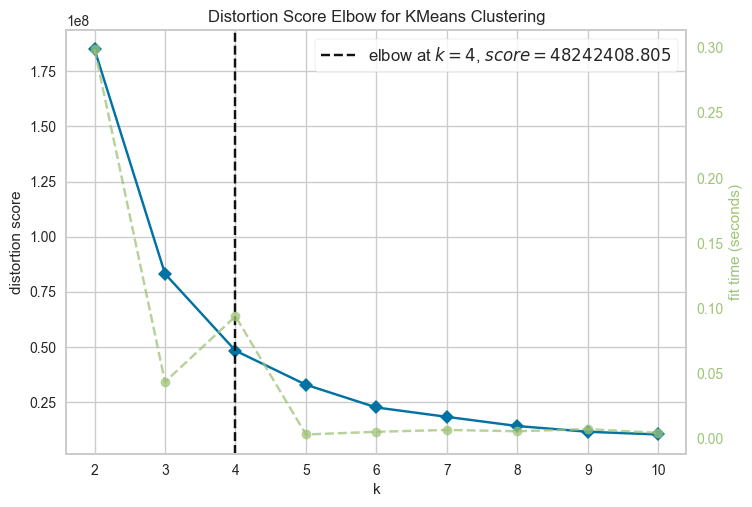

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [20]:
# Clustering with KMean Clustering and visualizing clusters
elbow_m = KElbowVisualizer(KMeans(), k=10)
elbow_m.fit(pca_ds)
elbow_m.show()

## Adapt Kmean's number of clusters --> n = 4

Since we want to compare the clustering models with kmeans model, we are adapting n = 4 from Kmeans.

In [21]:
# Initiating the Agglomerative Clustering model
ac = AgglomerativeClustering(n_clusters=4)
yhat_ac = ac.fit_predict(pca_ds)
ac_score = silhouette_score(pca_ds, yhat_ac)
print("Silhouette Score For Agglomerative Clustering", ac_score)

Silhouette Score For Agglomerative Clustering 0.6226302240321459


In [22]:
kmeans = KMeans(n_clusters=4)
yhat_kmeans = kmeans.fit_predict(pca_ds)
k_score = silhouette_score(pca_ds, yhat_kmeans)
print("Silhouette Score For K-means Clustering:", k_score)

Silhouette Score For K-means Clustering: 0.627857010937037


In [25]:
dbscan = DBSCAN(eps=0.5, min_samples=5)  

# Fit the model to the data and predict cluster labels
yhat_dbscan = dbscan.fit_predict(pca_ds)

# Check the unique cluster labels assigned by DBSCAN
unique_labels = np.unique(yhat_dbscan)

# give warning if there is only one cluster label
if len(unique_labels) > 1:
    # Calculate the silhouette score for DBSCAN clustering
    dbscan_score = silhouette_score(pca_ds, yhat_dbscan)
    print("Silhouette Score For DBSCAN Clustering:", dbscan_score)
else:
    dbscan_score = 0
    print("DBSCAN clustering did not assign more than one cluster label.")


DBSCAN clustering did not assign more than one cluster label.


In [26]:
gmm = GaussianMixture(n_components=4)

# Fit the model to the data and predict cluster labels
yhat_gmm = gmm.fit_predict(pca_ds)

# Calculate the silhouette score for GMM clustering
gmm_score = silhouette_score(pca_ds, yhat_gmm)
print("Silhouette Score For Gaussian Mixture Model Clustering:", gmm_score)

Silhouette Score For Gaussian Mixture Model Clustering: 0.5269411537347369


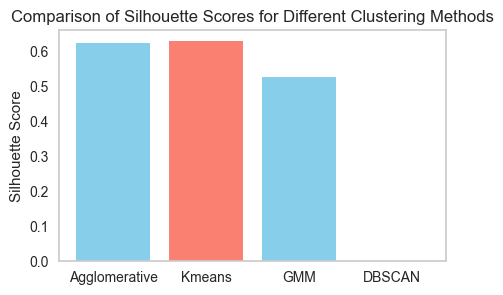

In [29]:
def plot_and_highlight_max(a, b, c, d):
    heights = [a, b, c, d]
    
    # Find the maximum value among a, b, c
    max_value = max(a, b, c, d)
    max_index = heights.index(max_value)  # Index for the highest value
    
    # Colors for the bars
    colors = ['skyblue'] * len(heights)  # Default color for all bars
    colors[max_index] = 'salmon'  # Color the maximum value bar as salmon
    
    labels = ['Agglomerative', 'Kmeans', 'GMM', 'DBSCAN']
    
    # Plot the bar graph with implicit x-values and custom labels
    plt.figure(figsize=(5, 3))
    plt.bar(labels, heights, color=colors)
    plt.xticks(range(len(heights)), labels)
    
    # Set labels and title
    plt.ylabel('Silhouette Score')
    plt.title('Comparison of Silhouette Scores for Different Clustering Methods')

    
    # Show the plot
    
    plt.grid(False)
    plt.show()
    

plot_and_highlight_max(ac_score, k_score, gmm_score, dbscan_score)

## Plot Clusters

/var/folders/z4/djkh1_vd3bb6xf3hy80b_l9m0000gn/T/ipykernel_78047/2369662460.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Clusters"] = yhat_kmeans


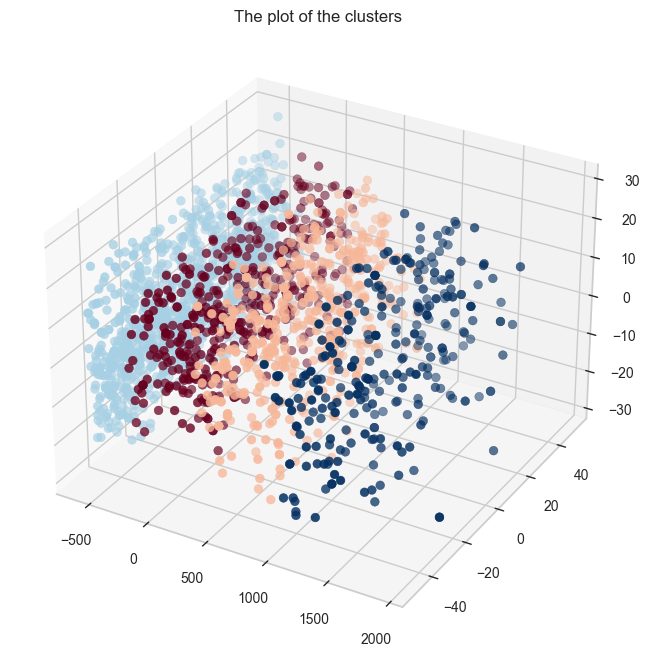

In [69]:
pca_ds["Clusters"] = yhat_kmeans
data["Clusters"] = yhat_kmeans
df["Clusters"] = yhat_kmeans

# Plotting the clusters
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111, projection='3d')
ax.scatter(pca_ds["col1"], pca_ds["col2"], pca_ds["col3"], s=40, c=pca_ds["Clusters"], cmap='RdBu')
ax.set_title("The plot of the clusters")
plt.show()

/var/folders/z4/djkh1_vd3bb6xf3hy80b_l9m0000gn/T/ipykernel_78047/2715373086.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Clusters", data=df, palette="RdBu")


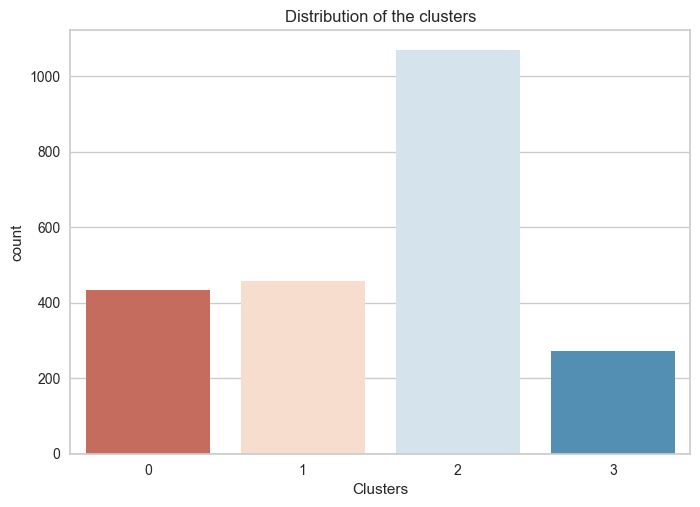

In [70]:
# Distribution of the clusters
sns.countplot(x="Clusters", data=df, palette="RdBu")
plt.title("Distribution of the clusters")
plt.show()

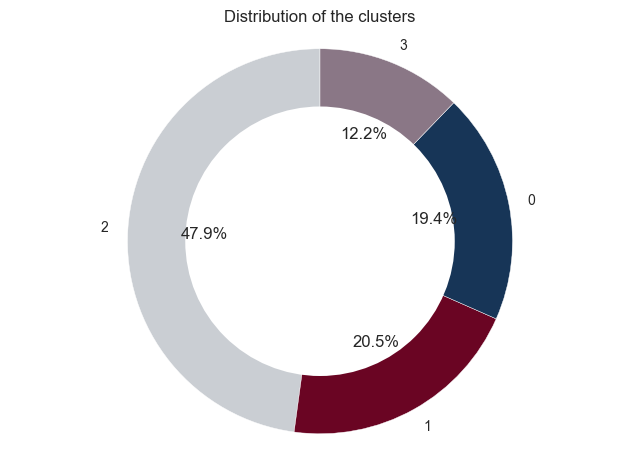

In [71]:
cluster_counts = df['Clusters'].value_counts()
labels = cluster_counts.index
sizes = cluster_counts.values

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#caced3', '#6a0523', '#173557', '#8a7786'], wedgeprops={'edgecolor': 'white'})

# Draw a white circle at the center to create a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')
plt.title("Distribution of the clusters")
plt.show()

# Recency Graphs

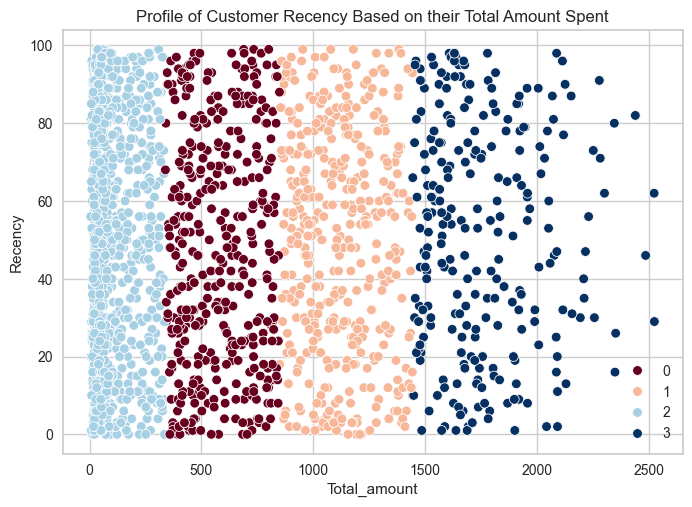

In [72]:
# Profile of a group of individuals based on their income and spending habits
sns.scatterplot(data=df, x="Total_amount", y="Recency", hue="Clusters", palette="RdBu")
plt.title("Profile of Customer Recency Based on their Total Amount Spent")
plt.legend()
plt.show()

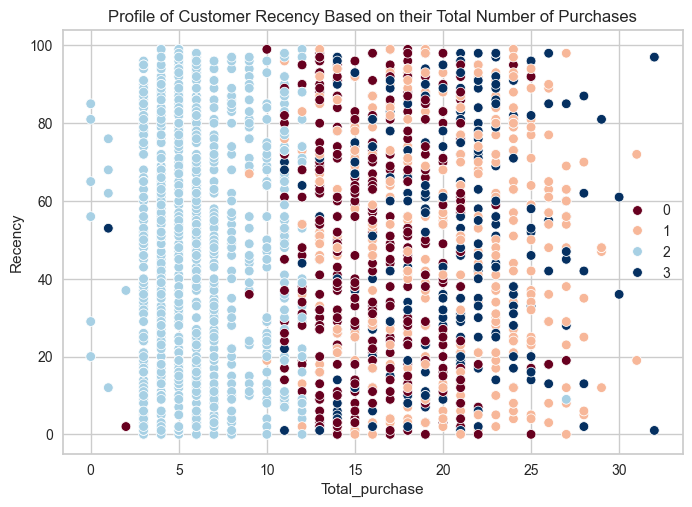

In [73]:
# Profile of a group of individuals based on their income and spending habits
sns.scatterplot(data=df, x="Total_purchase", y="Recency", hue="Clusters", palette="RdBu")
plt.title("Profile of Customer Recency Based on their Total Number of Purchases")
plt.legend()
plt.show()

# Frequency Graphs

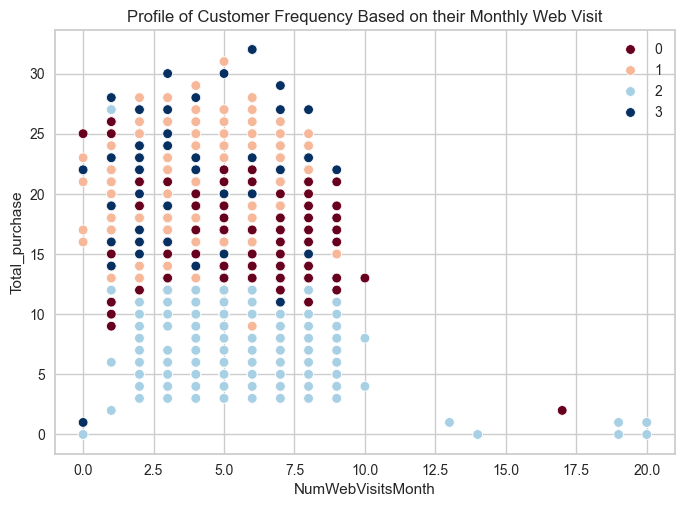

In [74]:
# Profile of a group of individuals based on their income and spending habits
sns.scatterplot(data=df, x="NumWebVisitsMonth", y="Total_purchase", hue="Clusters", palette="RdBu")
plt.title("Profile of Customer Frequency Based on their Monthly Web Visit")
plt.legend()
plt.show()

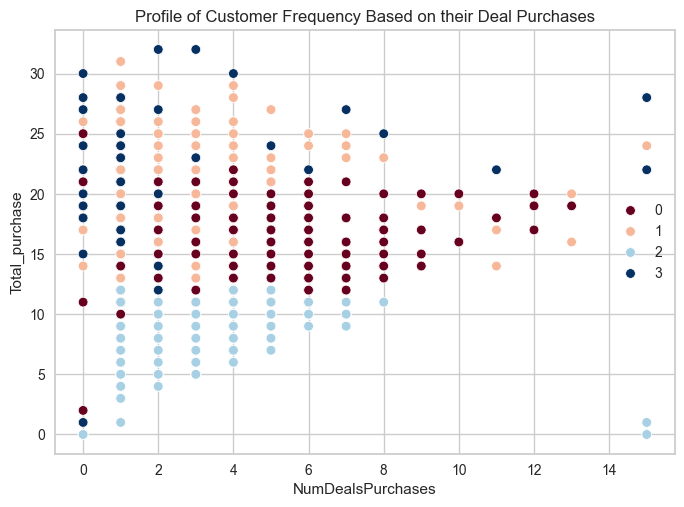

In [75]:
# Profile of a group of individuals based on their income and spending habits
sns.scatterplot(data=df, x="NumDealsPurchases", y="Total_purchase", hue="Clusters", palette="RdBu")
plt.title("Profile of Customer Frequency Based on their Deal Purchases")
plt.legend()
plt.show()

# Monetary Value Graphs

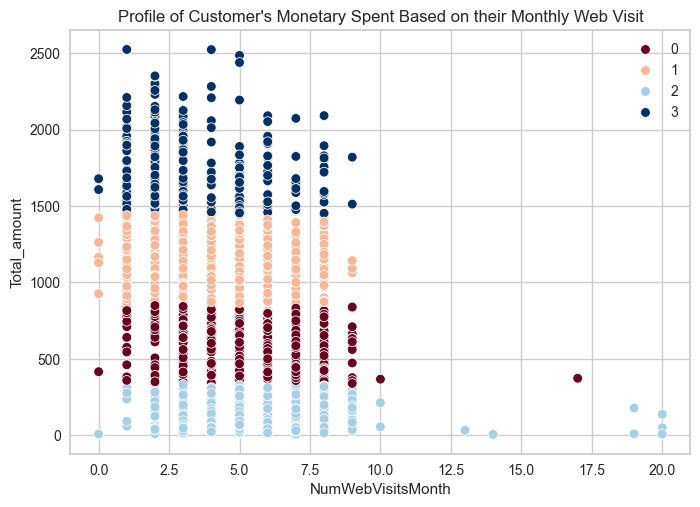

In [76]:
# Profile of a group of individuals based on their income and spending habits
sns.scatterplot(data=df, x="NumWebVisitsMonth", y="Total_amount", hue="Clusters", palette="RdBu")
plt.title("Profile of Customer's Monetary Spent Based on their Monthly Web Visit")
plt.legend()
plt.show()

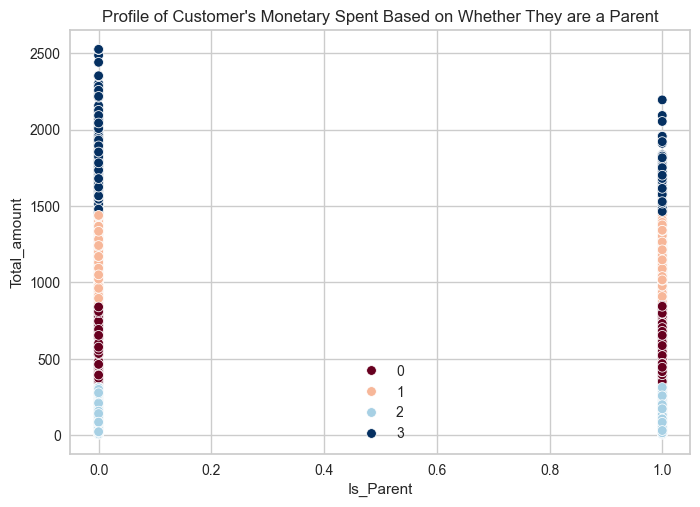

In [77]:
# Profile of a group of individuals based on their income and spending habits
sns.scatterplot(data=df, x="Is_Parent", y="Total_amount", hue="Clusters", palette="RdBu")
plt.title("Profile of Customer's Monetary Spent Based on Whether They are a Parent")
plt.legend()
plt.show()

# Other Graphs

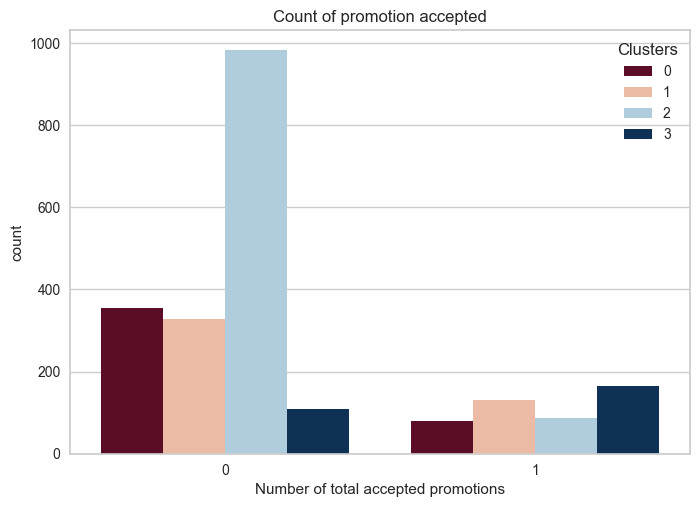

In [78]:
# Plotting count of total campaign accepted
plt.figure()
fig = sns.countplot(data=df, x="Cmp_Attitude", hue="Clusters", palette="RdBu")
fig.set_title("Count of promotion accepted")
fig.set_xlabel("Number of total accepted promotions")
# fig.set_xticklabels([])  # Hide x-axis labels
plt.show()

/var/folders/z4/djkh1_vd3bb6xf3hy80b_l9m0000gn/T/ipykernel_78047/1556911110.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl = sns.boxenplot(data=df, x="Clusters", y="NumDealsPurchases", palette="RdBu")


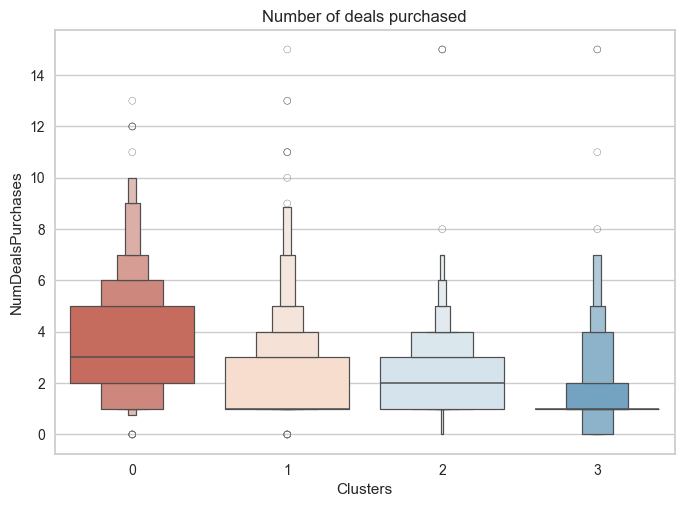

In [79]:
# Plotting the number of deals purchased
plt.figure()
pl = sns.boxenplot(data=df, x="Clusters", y="NumDealsPurchases", palette="RdBu")
pl.set_title("Number of deals purchased")
plt.show()

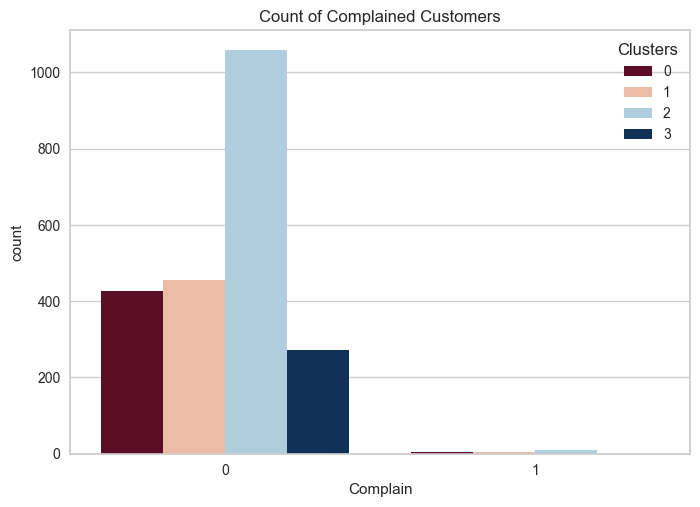

In [80]:
# Plotting the complain
plt.figure()
pl = sns.countplot(data=df, x="Complain", hue="Clusters", palette="RdBu")
pl.set_title("Count of Complained Customers")
plt.show()

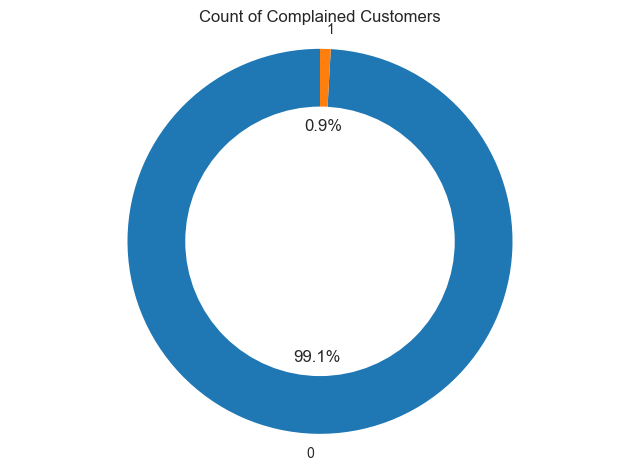

In [81]:
plt.figure()
complain_counts = df['Complain'].value_counts()
plt.pie(complain_counts, labels=complain_counts.index, autopct='%1.1f%%', startangle=90, colors=['#1f77b4', '#ff7f0e'])
plt.title("Count of Complained Customers")
plt.gca().add_artist(plt.Circle((0,0),0.70,fc='white'))
plt.axis('equal')
plt.show()


/var/folders/z4/djkh1_vd3bb6xf3hy80b_l9m0000gn/T/ipykernel_78047/4078641547.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl = sns.boxenplot(data=df, x="Clusters", y="Total_purchase", palette="RdBu")


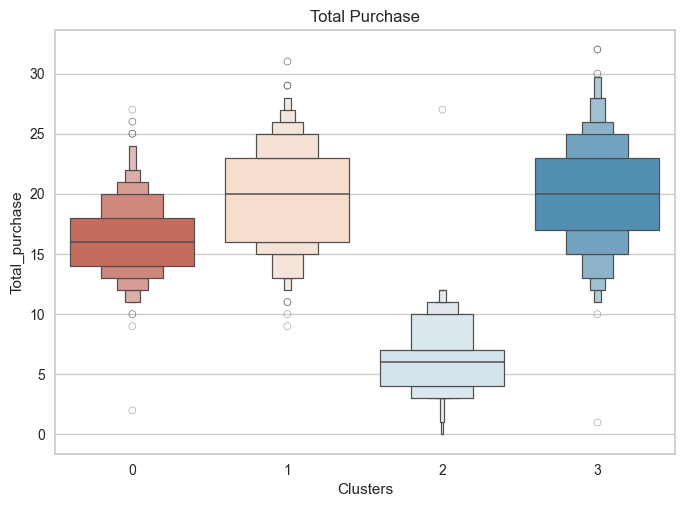

In [82]:
# Plotting the marriage
plt.figure()
pl = sns.boxenplot(data=df, x="Clusters", y="Total_purchase", palette="RdBu")
pl.set_title("Total Purchase")
plt.show()

/var/folders/z4/djkh1_vd3bb6xf3hy80b_l9m0000gn/T/ipykernel_78047/2984879436.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl = sns.boxenplot(data=df, x="Clusters", y="Family_Size", palette="RdBu")


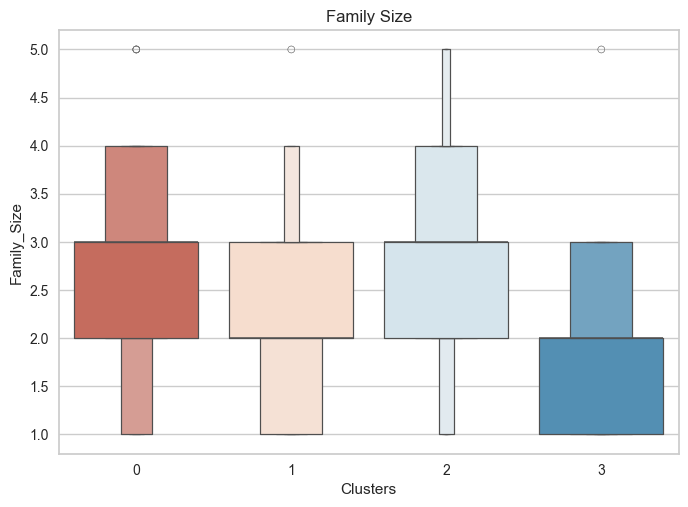

In [83]:
# Plotting the marriage
plt.figure()
pl = sns.boxenplot(data=df, x="Clusters", y="Family_Size", palette="RdBu")
pl.set_title("Family Size")
plt.show()

/var/folders/z4/djkh1_vd3bb6xf3hy80b_l9m0000gn/T/ipykernel_78047/1904231107.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl = sns.boxenplot(data=df, x="Clusters", y="Income", palette="RdBu")


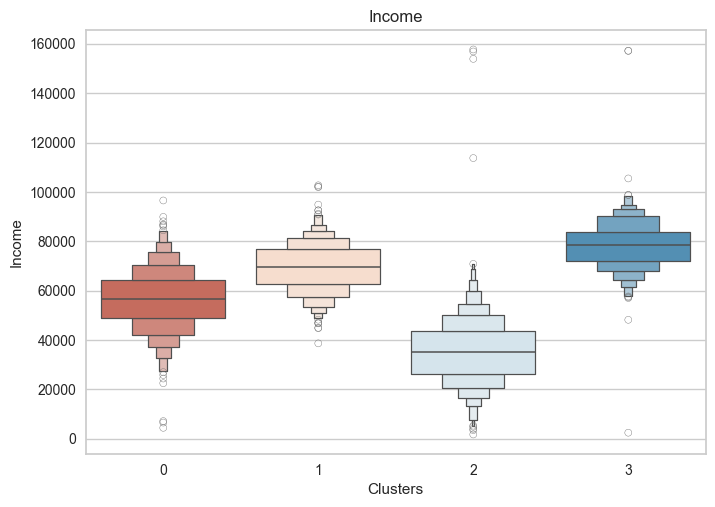

In [85]:
# Plotting the Income
plt.figure()
pl = sns.boxenplot(data=df, x="Clusters", y="Income", palette="RdBu")
pl.set_title("Income")
plt.show()

/var/folders/z4/djkh1_vd3bb6xf3hy80b_l9m0000gn/T/ipykernel_78047/1990358843.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl = sns.boxenplot(data=df, x="Clusters", y="Age", palette="RdBu")


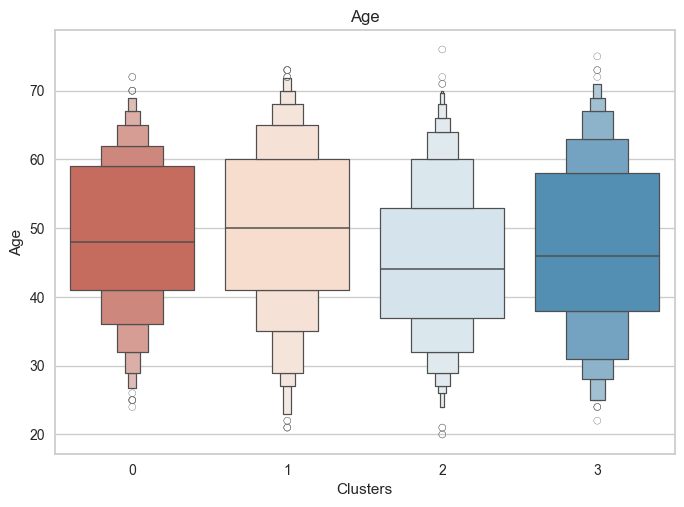

In [ ]:
# Plotting the Age
plt.figure()
pl = sns.boxenplot(data=df, x="Clusters", y="Age", palette="RdBu")
pl.set_title("Age")
plt.show()

/var/folders/z4/djkh1_vd3bb6xf3hy80b_l9m0000gn/T/ipykernel_78047/351013550.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl = sns.boxenplot(data=df, x="Clusters", y="Member_Year", palette="RdBu")


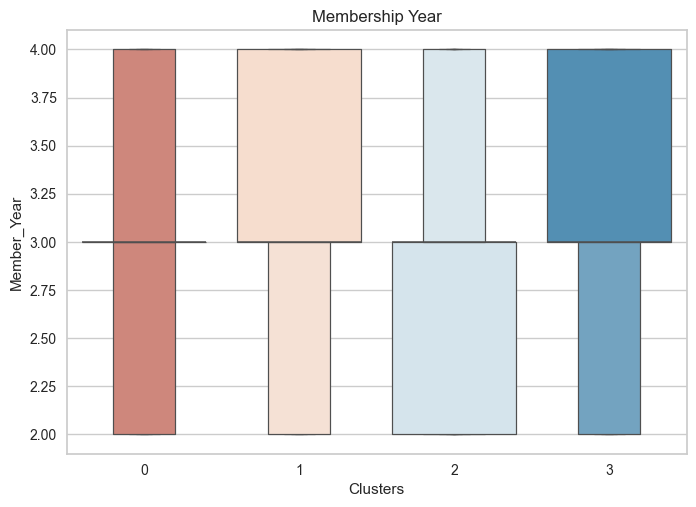

In [86]:
# Plotting the Member_Year
plt.figure()
pl = sns.boxenplot(data=df, x="Clusters", y="Member_Year", palette="RdBu")
pl.set_title("Membership Year")
plt.show()

/var/folders/z4/djkh1_vd3bb6xf3hy80b_l9m0000gn/T/ipykernel_78047/869327685.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl = sns.boxenplot(data=df, x="Clusters", y="Recency", palette="RdBu")


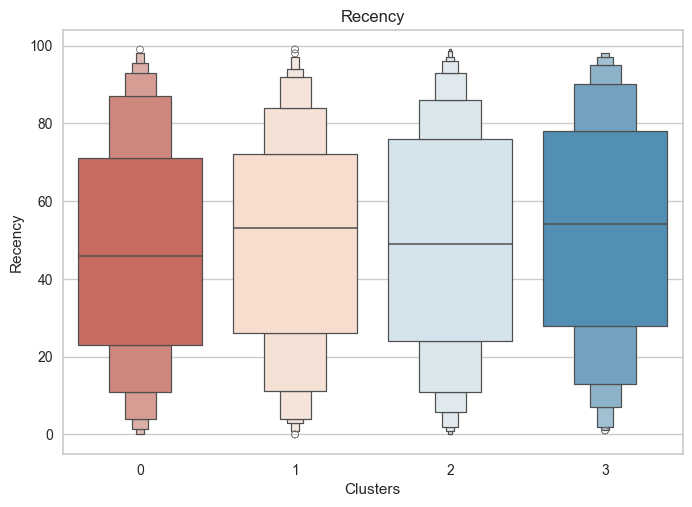

In [87]:
# Plotting the Recency
plt.figure()
pl = sns.boxenplot(data=df, x="Clusters", y="Recency", palette="RdBu")
pl.set_title("Recency")
plt.show()

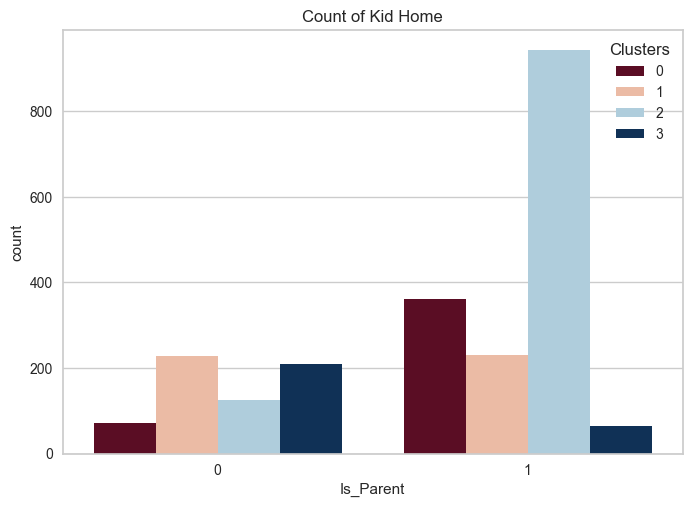

In [88]:
# Plotting the KidHome
plt.figure()
pl = sns.countplot(data=df, x="Is_Parent", hue="Clusters", palette="RdBu")
pl.set_title("Count of Kid Home")
plt.show()

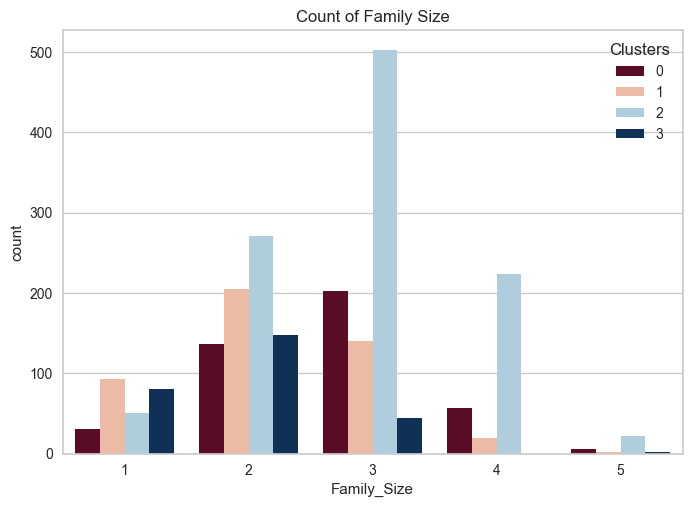

In [89]:
# Plotting the Teenhome
plt.figure()
pl = sns.countplot(data=df, x="Family_Size", hue="Clusters", palette="RdBu")
pl.set_title("Count of Family Size")
plt.show()

/var/folders/z4/djkh1_vd3bb6xf3hy80b_l9m0000gn/T/ipykernel_78047/2148296671.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl = sns.boxenplot(data=df, x="Clusters", y="MntWines", palette="RdBu")


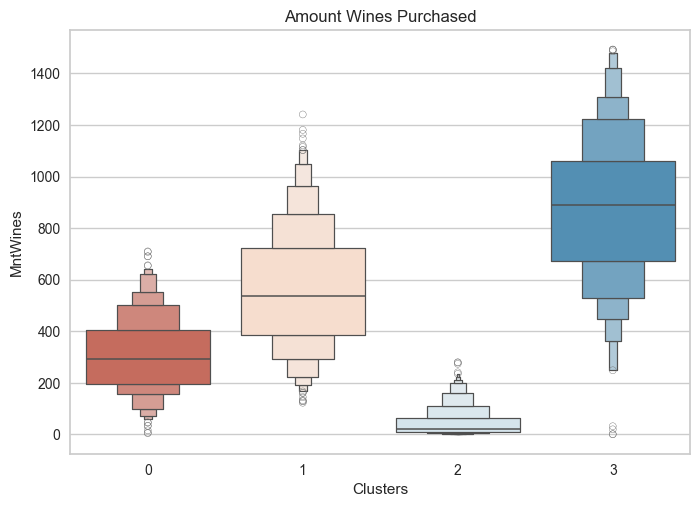

In [90]:
# Plotting the MntWines
plt.figure()
pl = sns.boxenplot(data=df, x="Clusters", y="MntWines", palette="RdBu")
pl.set_title("Amount Wines Purchased")
plt.show()

/var/folders/z4/djkh1_vd3bb6xf3hy80b_l9m0000gn/T/ipykernel_78047/1970196389.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl = sns.boxenplot(data=df, x="Clusters", y="MntFruits", palette="RdBu")


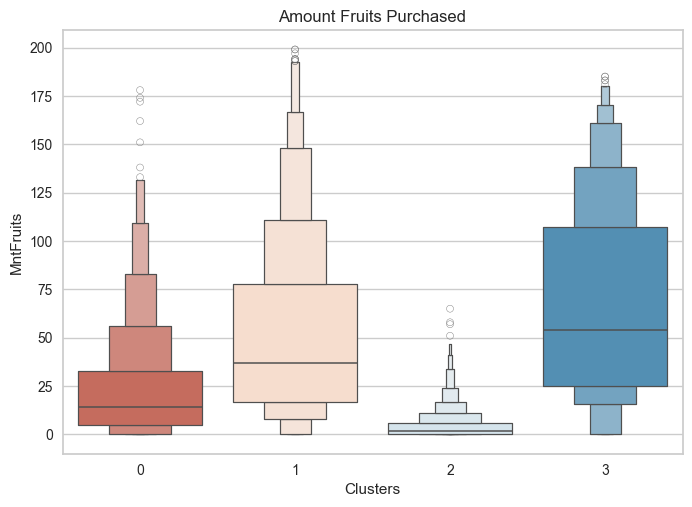

In [91]:
# Plotting the MntFruits
plt.figure()
pl = sns.boxenplot(data=df, x="Clusters", y="MntFruits", palette="RdBu")
pl.set_title("Amount Fruits Purchased")
plt.show()

/var/folders/z4/djkh1_vd3bb6xf3hy80b_l9m0000gn/T/ipykernel_78047/543527507.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl = sns.boxenplot(data=df, x="Clusters", y="MntMeatProducts", palette="RdBu")


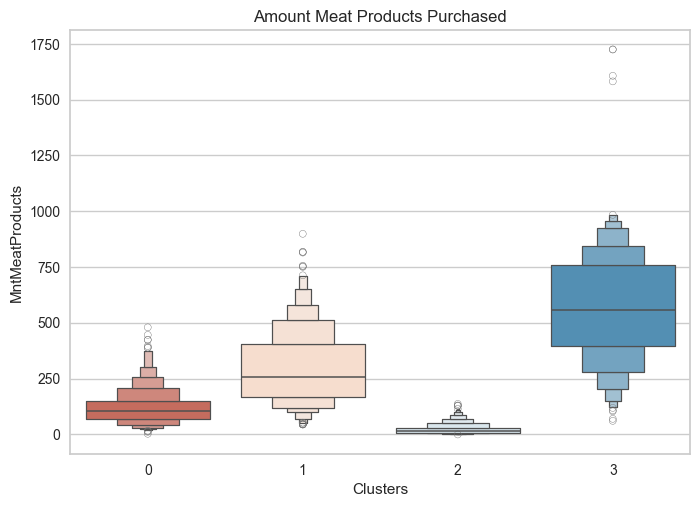

In [92]:
# Plotting the MntMeatProducts
plt.figure()
pl = sns.boxenplot(data=df, x="Clusters", y="MntMeatProducts", palette="RdBu")
pl.set_title("Amount Meat Products Purchased")
plt.show()

/var/folders/z4/djkh1_vd3bb6xf3hy80b_l9m0000gn/T/ipykernel_78047/3041324988.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl = sns.boxenplot(data=df, x="Clusters", y="MntFishProducts", palette="RdBu")


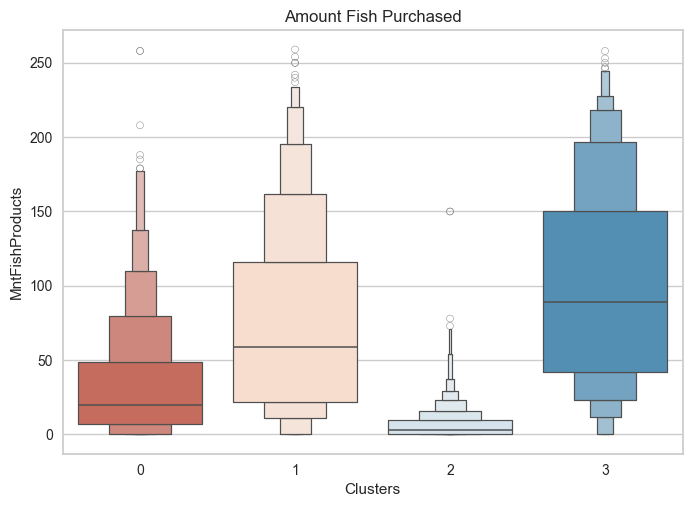

In [93]:
# Plotting the MntFishProducts
plt.figure()
pl = sns.boxenplot(data=df, x="Clusters", y="MntFishProducts", palette="RdBu")
pl.set_title("Amount Fish Purchased")
plt.show()

/var/folders/z4/djkh1_vd3bb6xf3hy80b_l9m0000gn/T/ipykernel_78047/2518104846.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl = sns.boxenplot(data=df, x="Clusters", y="MntSweetProducts", palette="RdBu")


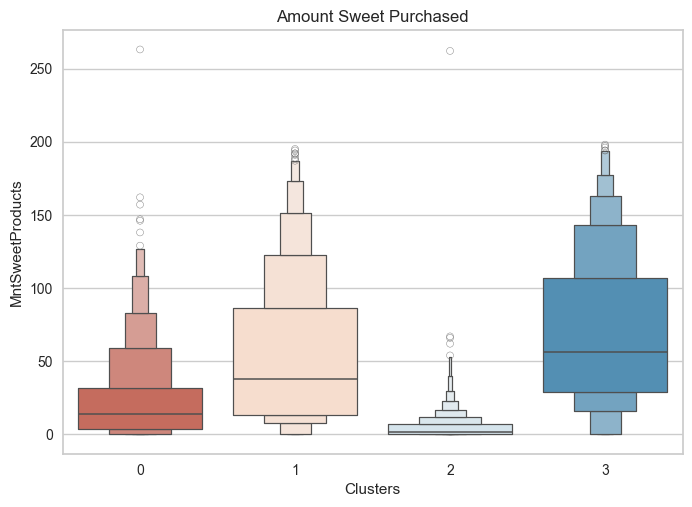

In [94]:
# Plotting the MntSweetProducts
plt.figure()
pl = sns.boxenplot(data=df, x="Clusters", y="MntSweetProducts", palette="RdBu")
pl.set_title("Amount Sweet Purchased")
plt.show()

/var/folders/z4/djkh1_vd3bb6xf3hy80b_l9m0000gn/T/ipykernel_78047/3497897822.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl = sns.boxenplot(data=df, x="Clusters", y="MntGoldProds", palette="RdBu")


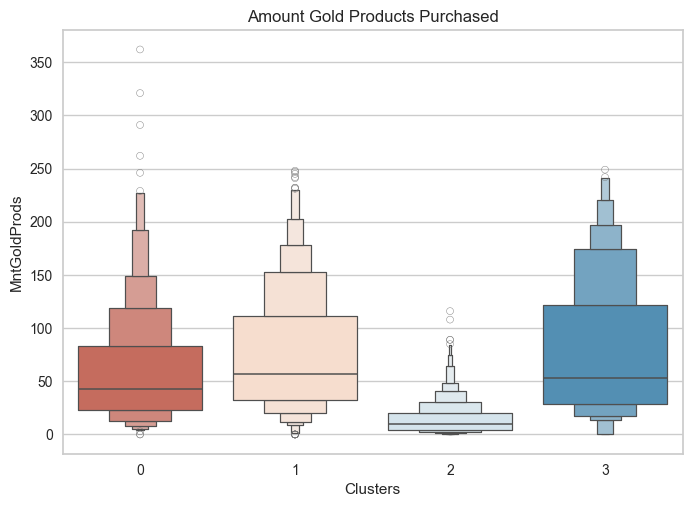

In [95]:
# Plotting the MntGoldProds
plt.figure()
pl = sns.boxenplot(data=df, x="Clusters", y="MntGoldProds", palette="RdBu")
pl.set_title("Amount Gold Products Purchased")
plt.show()

/var/folders/z4/djkh1_vd3bb6xf3hy80b_l9m0000gn/T/ipykernel_78047/212816860.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl = sns.boxenplot(data=df, x="Clusters", y="NumWebPurchases", palette="RdBu")


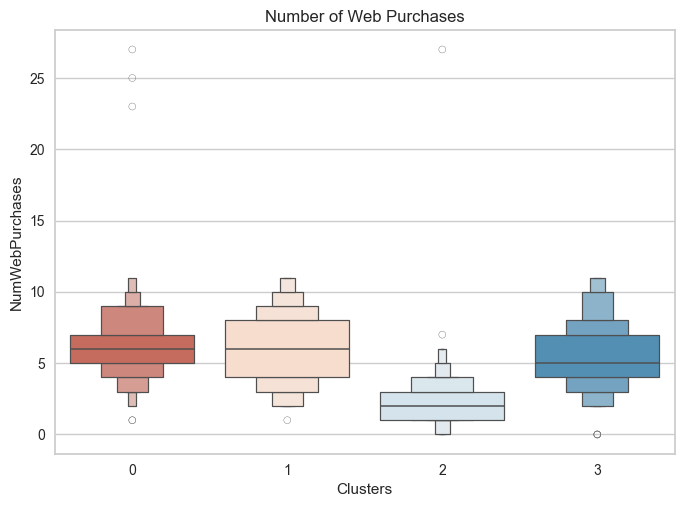

In [96]:
# Plotting the NumWebPurchases
plt.figure()
pl = sns.boxenplot(data=df, x="Clusters", y="NumWebPurchases", palette="RdBu")
pl.set_title("Number of Web Purchases")
plt.show()

/var/folders/z4/djkh1_vd3bb6xf3hy80b_l9m0000gn/T/ipykernel_78047/483457351.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl = sns.boxenplot(data=df, x="Clusters", y="NumStorePurchases", palette="RdBu")


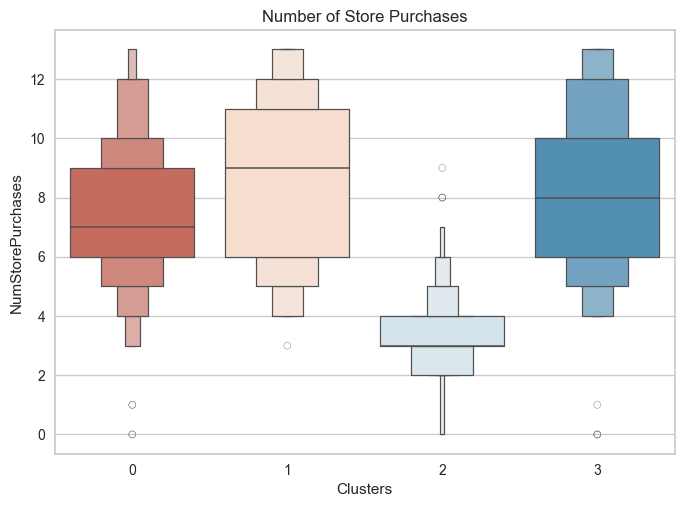

In [97]:
# Plotting the NumStorePurchases
plt.figure()
pl = sns.boxenplot(data=df, x="Clusters", y="NumStorePurchases", palette="RdBu")
pl.set_title("Number of Store Purchases")
plt.show()

In [98]:
df["PercentWebpurchases"]= (df["NumWebPurchases"] / (df["NumWebPurchases"] + df["NumStorePurchases"])) * 100

/var/folders/z4/djkh1_vd3bb6xf3hy80b_l9m0000gn/T/ipykernel_78047/163370527.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl = sns.boxenplot(data=df, x="Clusters", y="PercentWebpurchases", palette="RdBu")


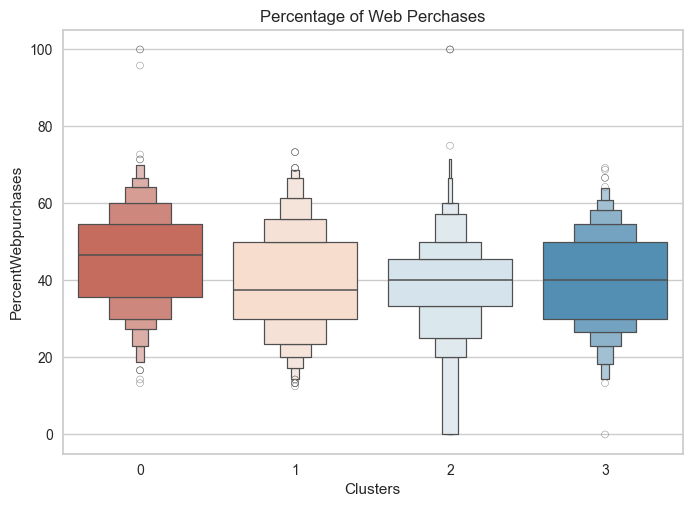

In [99]:
# Plotting the PercentWebpurchases
plt.figure()
pl = sns.boxenplot(data=df, x="Clusters", y="PercentWebpurchases", palette="RdBu")
pl.set_title("Percentage of Web Perchases")
plt.show()

/var/folders/z4/djkh1_vd3bb6xf3hy80b_l9m0000gn/T/ipykernel_78047/3012047879.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl = sns.boxenplot(data=df, x="Clusters", y="NumCatalogPurchases", palette="RdBu")


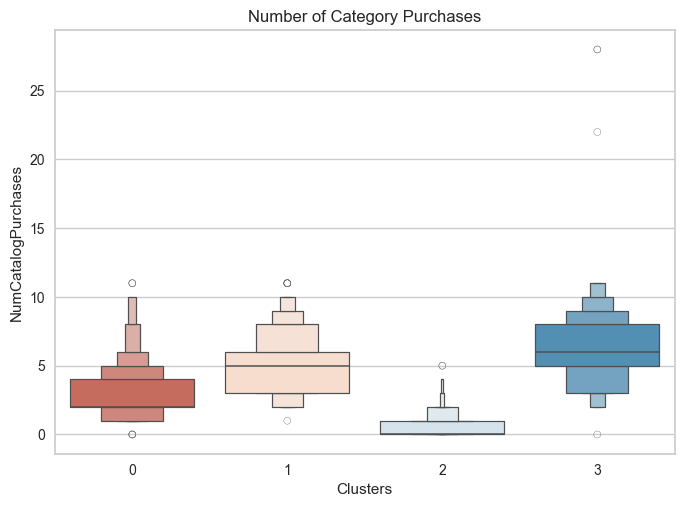

In [100]:
# Plotting the NumCatalogPurchases
plt.figure()
pl = sns.boxenplot(data=df, x="Clusters", y="NumCatalogPurchases", palette="RdBu")
pl.set_title("Number of Category Purchases")
plt.show()

/var/folders/z4/djkh1_vd3bb6xf3hy80b_l9m0000gn/T/ipykernel_78047/4141212197.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl = sns.boxenplot(data=df, x="Clusters", y="NumWebVisitsMonth", palette="RdBu")


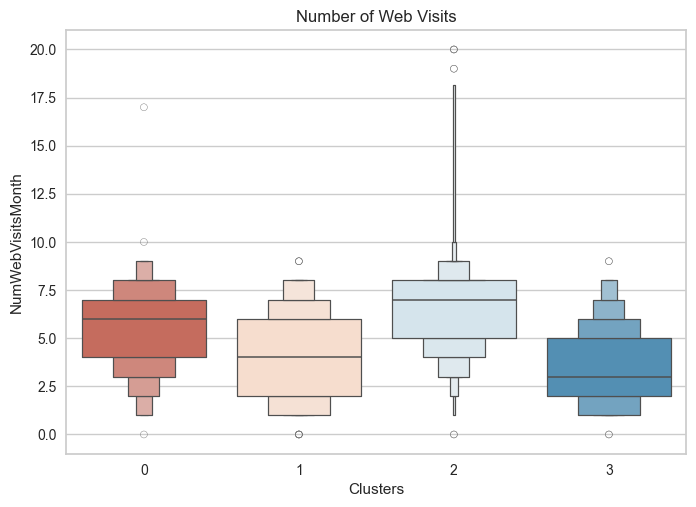

In [101]:
# Plotting the NumWebVisitsMonth
plt.figure()
pl = sns.boxenplot(data=df, x="Clusters", y="NumWebVisitsMonth", palette="RdBu")
pl.set_title("Number of Web Visits")
plt.show()

# Export Cluster data

In [149]:
data.to_csv('./preprocessed_data/Clustered_with_Total_purchase.csv', index=False)

In [150]:
data1.to_csv('./preprocessed_data/Clustered_without_Total_purchase.csv', index=False)